In [12]:
from openpiv import tools, pyprocess, validation, filters, scaling
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:

# Parameters for PIV
winsize = 32      # Interrogation window size in pixels
searchsize = 38   # Search area size in the second frame
overlap = 17      # Overlap between interrogation windows
dt = 0.02         # Time interval between frames in seconds
scaling_factor = 96.52  # Convert pixels to millimeters (adjust based on real-world measurements)


In [3]:

# Directory to save frames
output_dir = 'frames'
os.makedirs(output_dir, exist_ok=True)


In [5]:

# Directory containing the frames
frame_dir = 'frames'
frames = sorted([f for f in os.listdir(frame_dir) if f.endswith('.png')])

In [6]:
# Choose how many frames you want to process (e.g., 40 frames)
num_frames_to_process = 40
interval = len(frames) // num_frames_to_process


In [7]:
# Initialize lists to accumulate the velocity fields
all_u = []
all_v = []
all_x = []
all_y = []

In [8]:
# Loop through the video frames pairwise, sampling every nth frame
for i in range(0, len(frames) - interval, interval):
    frame_a_path = os.path.join(frame_dir, frames[i])
    frame_b_path = os.path.join(frame_dir, frames[i + interval])

    # Read the sampled frames
    frame_a = tools.imread(frame_a_path)
    frame_b = tools.imread(frame_b_path)

    # Compute the velocity field for this pair of frames
    u, v, sig2noise = pyprocess.extended_search_area_piv(
        frame_a.astype(np.int32),
        frame_b.astype(np.int32),
        window_size=winsize,
        overlap=overlap,
        dt=dt,
        search_area_size=searchsize,
        sig2noise_method='peak2peak',
    )

    # Get coordinates
    x, y = pyprocess.get_coordinates(
        image_size=frame_a.shape,
        search_area_size=searchsize,
        overlap=overlap,
    )

    # Validate and filter out unreliable vectors
    invalid_mask = validation.sig2noise_val(
        sig2noise,
        threshold=1.05,
    )
    u_filtered, v_filtered = filters.replace_outliers(
        u, v,
        invalid_mask,
        method='localmean',
        max_iter=3,
        kernel_size=3,
    )

    # Scale the velocity field
    x_scaled, y_scaled, u_scaled, v_scaled = scaling.uniform(
        x, y, u_filtered, v_filtered,
        scaling_factor=scaling_factor,
    )

    # Transform coordinates (optional)
    x_final, y_final, u_final, v_final = tools.transform_coordinates(x_scaled, y_scaled, u_scaled, v_scaled)

    # Accumulate the velocity fields and coordinates
    all_u.append(u_final)
    all_v.append(v_final)
    all_x.append(x_final)
    all_y.append(y_final)

In [9]:
# Convert accumulated lists to arrays
u_combined = np.mean(np.stack(all_u), axis=0)
v_combined = np.mean(np.stack(all_v), axis=0)
x_combined = all_x[0]  # Assuming all coordinates are the same
y_combined = all_y[0]  # Assuming all coordinates are the same

In [10]:
# Save the combined velocity vector field to a file
tools.save('velocity_field_40frames_full_lenghth_combined.txt', x_combined, y_combined, u_combined, v_combined, np.ones_like(u_combined))

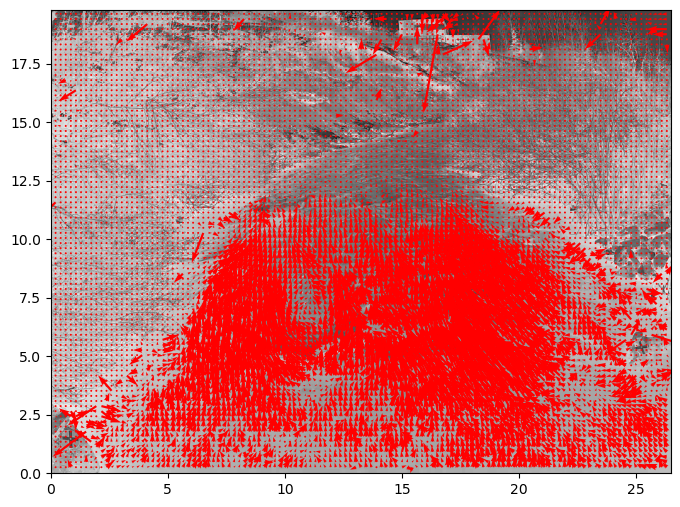

In [13]:
# Plot the combined velocity field over one of the frames
fig, ax = plt.subplots(figsize=(8, 8))
tools.display_vector_field(
    'velocity_field_combined.txt',
    ax=ax,
    scaling_factor=scaling_factor,
    scale=50,  # Defines the length of arrows
    width=0.0035,  # Thickness of arrows
    on_img=True,  # Overlay on the image
    image_name=os.path.join(frame_dir, frames[0]),  # Use the first frame as background
)
plt.show()


In [14]:
import numpy as np

# Assuming u_combined and v_combined are your velocity components
velocity_magnitude = np.sqrt(u_combined**2 + v_combined**2)

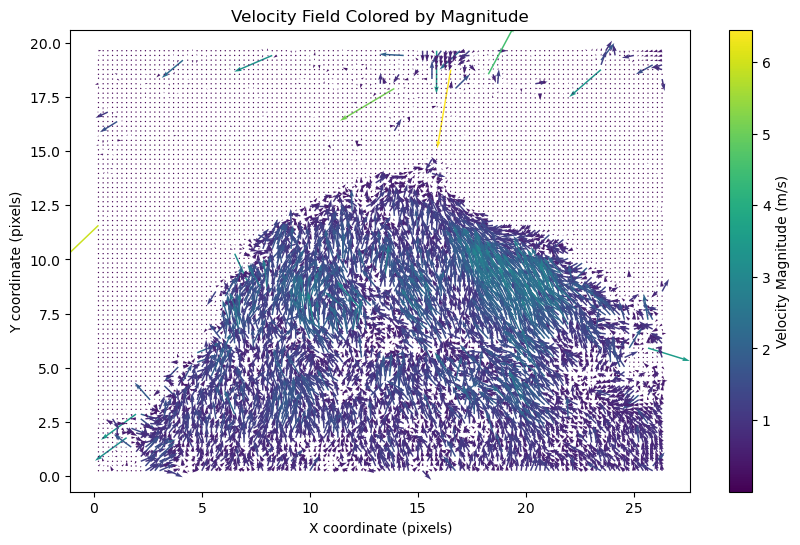

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Create a colormap for the velocity magnitude
magnitude = np.sqrt(u_combined**2 + v_combined**2)  # Velocity magnitude

# Create a quiver plot where the color represents the velocity magnitude
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the vector field with colors representing the magnitude of the velocity
q = ax.quiver(x_combined, y_combined, u_combined, v_combined, magnitude, cmap='viridis', scale=50)

# Add a color bar to show the velocity scale
cbar = plt.colorbar(q, ax=ax)
cbar.set_label('Velocity Magnitude (m/s)')

plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')
plt.title('Velocity Field Colored by Magnitude')
plt.show()


In [19]:
# there are a few particles with high velocity which are causing the colormap to be skewed,
# to solve this problem, I will ignore some of them with higher velocity than a threshold
velocity_threshold = 2.0  # Define your threshold value
# Calculate the velocity magnitude
magnitude = np.sqrt(u_combined**2 + v_combined**2)

# Create a mask for velocities below the threshold
mask = magnitude <= velocity_threshold

# Apply the mask to the velocity components and coordinates
u_filtered = u_combined[mask]
v_filtered = v_combined[mask]
x_filtered = x_combined[mask]
y_filtered = y_combined[mask]
magnitude_filtered = magnitude[mask]


In [20]:
# Calculate the velocity magnitude
magnitude = np.sqrt(u_combined**2 + v_combined**2)

# Create a mask for velocities below the threshold
mask = magnitude <= velocity_threshold

# Apply the mask to the velocity components and coordinates
u_filtered = u_combined[mask]
v_filtered = v_combined[mask]
x_filtered = x_combined[mask]
y_filtered = y_combined[mask]
magnitude_filtered = magnitude[mask]


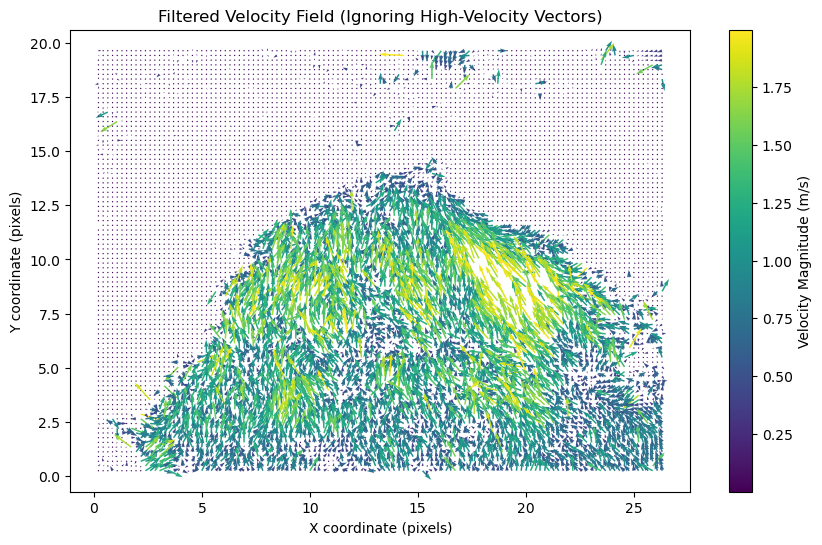

In [21]:
import matplotlib.pyplot as plt

# Plot the vector field with filtered values
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the filtered vector field with color representing velocity magnitude
q = ax.quiver(x_filtered, y_filtered, u_filtered, v_filtered, magnitude_filtered, cmap='viridis', scale=50)

# Add a color bar to show the velocity scale
cbar = plt.colorbar(q, ax=ax)
cbar.set_label('Velocity Magnitude (m/s)')

plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')
plt.title('Filtered Velocity Field (Ignoring High-Velocity Vectors)')
plt.show()


